# CS579: Lecture 04  

**Small Worlds**  
*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

**Milgram's experiment:**

![milgram](milgram.gif)

[Source](http://en.wikipedia.org/wiki/Small-world_experiment)

** 6-degrees of Kevin Bacon**
![kevin](kevin.jpg)
[Source](http://readingeagle.com/life/article/six-degress-of-kevin-bacon-a-game-changer#.VA35Z7ywKcI)

![triadic](triadic.png)

[Source](https://github.com/iit-cs579/main/blob/master/read/ek-20.pdf)

** What does it mean for a world to be small? **

- Sparsely connected (i.e., few edges)
- Despite the above, the path between two nodes is usually short

<br><br><br><br><br><br><br><br>

More concretely:

$$ L \propto \log  N $$

- $L$: average shortest path between any two nodes
- $N$: number of nodes

<br><br><br>
- Milgram's [original paper](http://www.jstor.org/stable/2786545) on small worlds
- Is the global friendship network really a small world? See [rebuttal paper](kleinfeld02.pdf)


<br><br><br>

- Only a small fraction of Milgram's letters actually made it to their destination
- Experiments to reproduce with email also have low success rates
- Success rates vary by demographics of person (e.g., income, ethnicity, ...)
- **Search** is an imporant problem
  - Given that we only have local information, how do we decide whom  
    to send the letter to?

**Generative models of graphs**

To understand what makes some graphs "small worlds" and some not,  
we will consider alternative ways graphs could form.


**Option 1: Random Graphs**

- Create $N$ nodes
- For each pair of nodes, draw an edge with probability $p$.

created random graph with p=0.5  N=20 E=102


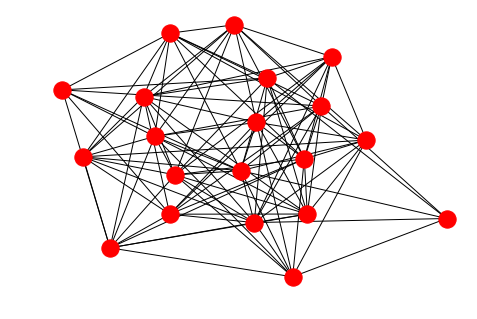

In [34]:
# Create a random graph with $n$ nodes, where each pair of nodes is linked at random with probability $p$.
%matplotlib inline
from itertools import combinations  # combinations([1,2,3], 2) -> [(1, 2), (1, 3), (2, 3)]
import matplotlib.pyplot as plt
import networkx as nx
import random

def random_graph(n, p, seed=1234):
    G = nx.Graph()
    random.seed(seed)
    G.add_nodes_from(range(n))
    for edge in combinations(range(n), 2):
        if random.random() < p:
            G.add_edge(edge[0], edge[1])
    print('created random graph with p=%g  N=%d E=%d' 
          % (p, len(G.nodes()), len(G.edges())))
    return G

G = random_graph(20, .5)
nx.draw(G)

In [35]:
def total_edges(N):
    return N * (N - 1) / 2

print('Graph density=%.3f' % 
      (1. * len(G.edges()) / total_edges(len(G.nodes()))))

Graph density=0.537


created random graph with p=0.1  N=20 E=22
created random graph with p=0.3  N=20 E=59
created random graph with p=0.5  N=20 E=102
created random graph with p=0.9  N=20 E=175


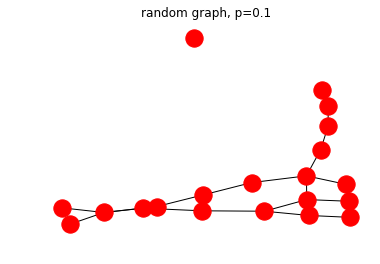

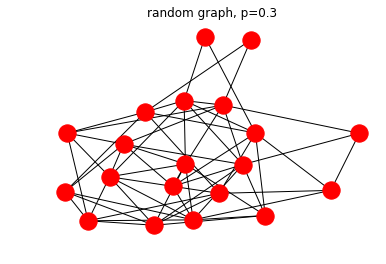

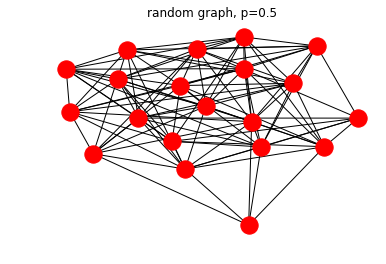

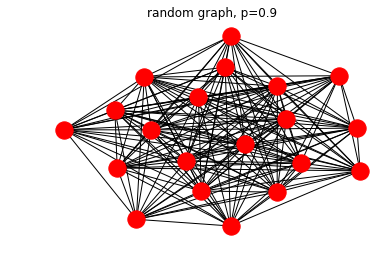

In [36]:
# Plot graphs with different $p$ values:
for p in [.1, .3, .5, .9]:
    plt.figure()
    plt.axis('off')
    nx.draw(random_graph(20, p))
    plt.title('random graph, p=%.1f' % p)


## Is this a realistic model of actual networks?

Compare with the important properties of graphs:
- Degree distribution: $P(k)$
- Clustering coefficient: $C$
- Node distance: $D$

In [6]:
# Let's plot the degree distribution again.
from collections import Counter
import numpy as np

def plot_degree_dist(G, title):
    degrees = list(dict(nx.degree(G)).values())
    degree_counts = Counter(degrees)
    
    p_k = [(degree, count / len(G.nodes()))
           for degree, count in degree_counts.items()]
    p_k = sorted(p_k)
    ks = [x[0] for x in p_k]
    x_pos = range(len(ks))
    plt.xlabel('$k$')
    plt.ylabel('$P(k)$')
    plt.bar(x_pos, [x[1] for x in p_k], align='center', alpha=0.4)
    plt.locator_params(nbins=10) 
    plt.title('Degree Distribution for %s (mean=%.2f, N=%d)' 
              % (title, np.mean(degrees), len(G.nodes())))

created random graph with p=0.1  N=100 E=467


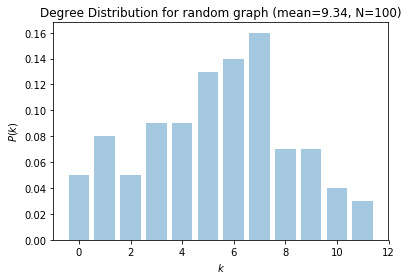

In [7]:
G = random_graph(100, .1)
plot_degree_dist(G, 'random graph')

In [8]:
import urllib
# Fetch co-author network from http://snap.stanford.edu/data/ca-GrQc.html
urllib.request.urlretrieve("http://snap.stanford.edu/data/ca-GrQc.txt.gz", "ca-GrQc.txt.gz")
coauthor = nx.read_edgelist('ca-GrQc.txt.gz')

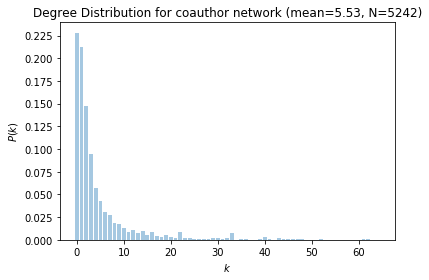

In [9]:
# Plot the citation degree distribution.
plot_degree_dist(coauthor, 'coauthor network')

created random graph with p=0.01  N=5242 E=137210


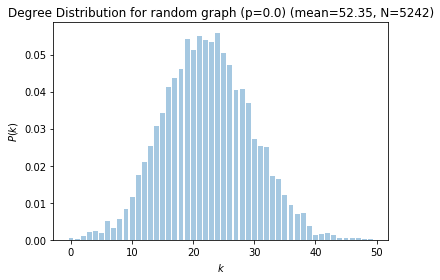

In [10]:
random_g = random_graph(len(coauthor.nodes()), .01)
plot_degree_dist(random_g, 'random graph (p=%.1f)' % .01)

** Random degree distribution is normal, but real degree distribution is skewed. **

**Average degree roughly 10x higher in random graph! (5.53 vs. 52.35)**

In [11]:
# Now let's compare the distribution of clustering coefficients.
def plot_clustering_dist(G, title):
    clustering_coef = list(nx.clustering(G).values())
    plt.hist(list(clustering_coef), alpha=0.4, bins=20)
    plt.xlabel('$C$')
    plt.ylabel('count')
    plt.title('Clustering Coefficient for %s (mean=%.2f)' % 
              (title, np.mean(clustering_coef)))

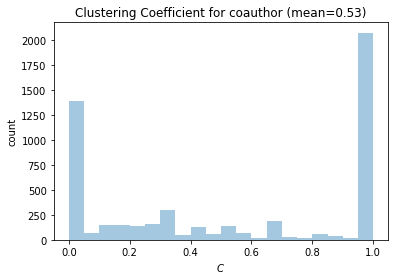

In [12]:
plot_clustering_dist(coauthor, 'coauthor')

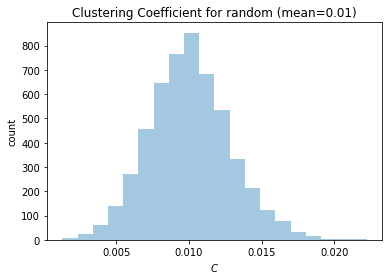

In [13]:
plot_clustering_dist(random_g, 'random')

** Real network: bi-modal distribution; random network: unimodal normal distribution **

**Real network has 50x more clustering, on average. (.53 vs .01)**

In [16]:
# Finally, let's compare the average shortest path (distance)
# This takes a while since all-pairs-shortest-paths is =~ $O(|V|^3)$
# See http://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm
# and https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm
def get_shortest_paths(G):
    lengths = nx.all_pairs_shortest_path_length(G)
    return [np.mean(list(paths.values()))
                    for paths in dict(lengths).values()]

def plot_shortest_paths_dist(G, title):
    means = get_shortest_paths(G)
    plt.hist(means, alpha=0.4)
    plt.xlabel('avg. shortest path')
    plt.ylabel('count')
    plt.title('Shortest Paths for %s (mean=%.2f)' 
              % (title, np.mean(means)))

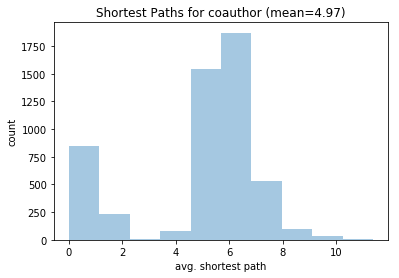

In [17]:
# slow!
plot_shortest_paths_dist(coauthor, 'coauthor')

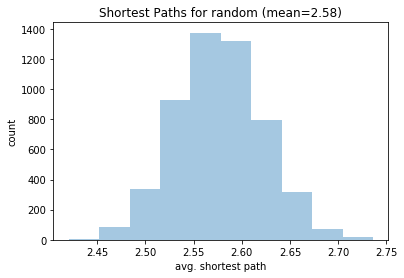

In [18]:
plot_shortest_paths_dist(random_g, 'random')

Our definition of small world was:
    
$$ L \propto \log  N $$

- $L$: average shortest path between any two nodes
- $N$: number of nodes

We can empirically check this relationship by generating random graphs of increasingly large $N$ and plotting the growth of $L$.
    

created random graph with p=0.01  N=50 E=9
created random graph with p=0.01  N=100 E=43
created random graph with p=0.01  N=150 E=94
created random graph with p=0.01  N=200 E=182
created random graph with p=0.01  N=250 E=290
created random graph with p=0.01  N=300 E=431
created random graph with p=0.01  N=350 E=578
created random graph with p=0.01  N=400 E=786
created random graph with p=0.01  N=450 E=998
created random graph with p=0.01  N=500 E=1244
created random graph with p=0.01  N=550 E=1492
created random graph with p=0.01  N=600 E=1794
created random graph with p=0.01  N=650 E=2091
created random graph with p=0.01  N=700 E=2433
created random graph with p=0.01  N=750 E=2788
created random graph with p=0.01  N=800 E=3145
created random graph with p=0.01  N=850 E=3558
created random graph with p=0.01  N=900 E=3980
created random graph with p=0.01  N=950 E=4460


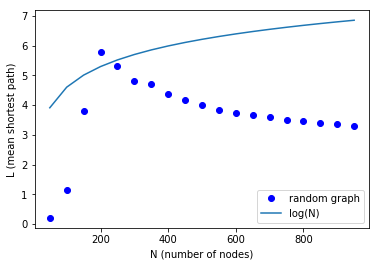

In [19]:
import math
Ls = []  # mean shortest paths.
ns = []  # number of nodes.
for n in range(50,1000)[::50]:
    Ls.append(np.mean(get_shortest_paths(random_graph(n, .01))))
    ns.append(n)

plt.plot(ns, Ls, 'bo', label='random graph')
plt.plot(ns, [math.log(n) for n in ns], label='log(N)')
plt.legend(loc='lower right')
plt.xlabel('N (number of nodes)')
plt.ylabel('L (mean shortest path)')
plt.show()

**Summary:** Random graphs are a poor match for degree distribution and clustering; close for distances.

<br><br><br>

**Option 2: $k$-Regular Graph**

- Every node has degree $k$

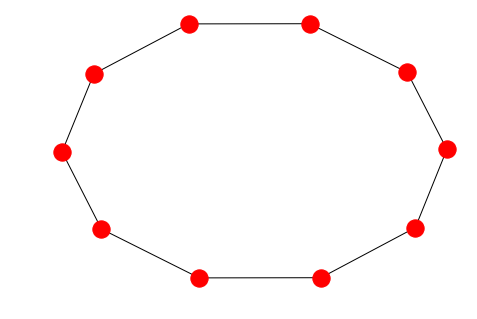

In [20]:
regular_g = nx.random_regular_graph(2, 10)
nx.draw(regular_g)
# This should really be a ring...

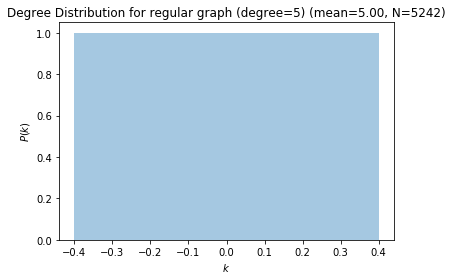

In [21]:
regular_g = nx.random_regular_graph(5, len(coauthor.nodes()))
plot_degree_dist(regular_g, 'regular graph (degree=5)')

** Obviously, all nodes have same degree (5) **

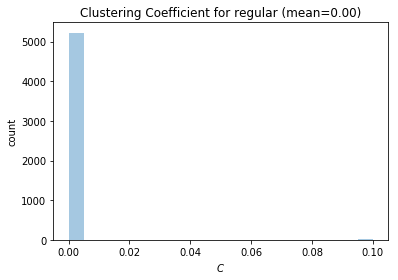

In [22]:
plot_clustering_dist(regular_g, 'regular')

** Clustering coefficient is almost always 0, by definition. **

(The generation algorithm may connect some neighbors to satisfy degree constraint.)

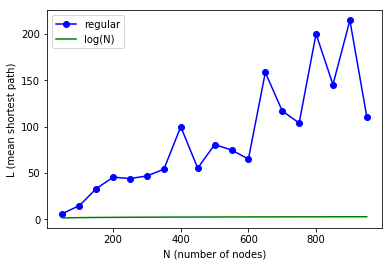

In [23]:
# Do regular graphs have L =~ log(N) growth?
import math
Ls = []
ns = []
for n in range(50,1000)[::50]:
    Ls.append(np.mean(get_shortest_paths(nx.random_regular_graph(2, n))))
    ns.append(n)

plt.plot(ns, Ls, 'bo-', label='regular')
plt.plot(ns, [math.log10(n) for n in ns], 'g-', label='log(N)')
plt.legend(loc='upper left')
plt.xlabel('N (number of nodes)')
plt.ylabel('L (mean shortest path)')
plt.show()

** Clearly, regular graphs are not very realistic. Are they useful? **

![small](small.png)

Source: [*Collective dynamics of 'small-world' networks.* Duncan J. Watts & Steven H. Strogatz](http://www.nature.com/nature/journal/v393/n6684/pdf/393440a0.pdf)

- **Regular** graphs have low clustering and high distance
- **Random** graphs have low clustering and low distance
- **Real** graphs have high clustering and low distance.

Need something in-between regular and random.

**Idea:** randomly "rewire" edges in regular graph to become more random.

**"Watts Strogatz" Model**

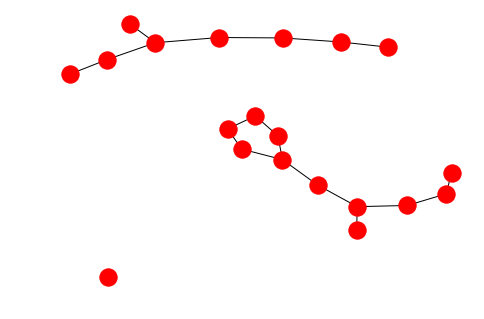

In [29]:
# Randomly rewire the edges of a regular graph, with probability $p$.
def rewire(G, p, seed=123):
    nodes = G.nodes()
    random.seed(seed)
    for edge in list(G.edges()):
        if random.random() < p:
            G.remove_edge(*edge)
            G.add_edge(edge[0], random.sample(nodes, 1)[0])
    return G

rewired = rewire(nx.random_regular_graph(2, 20), .1)
nx.draw(rewired)

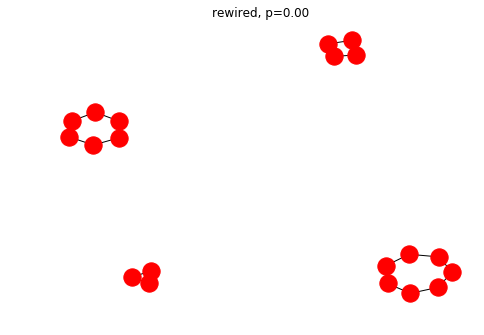

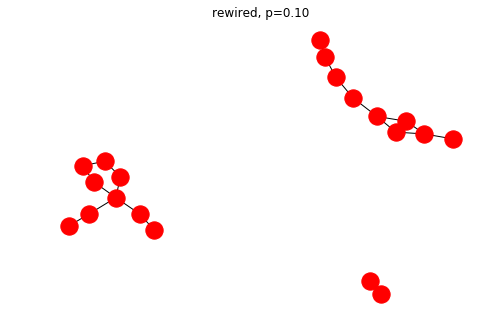

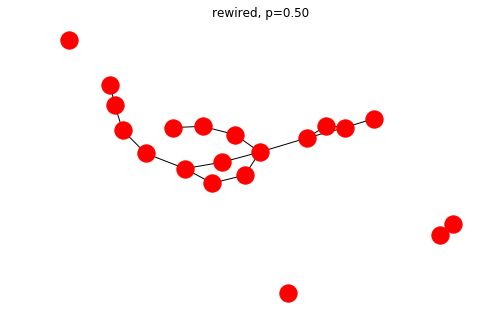

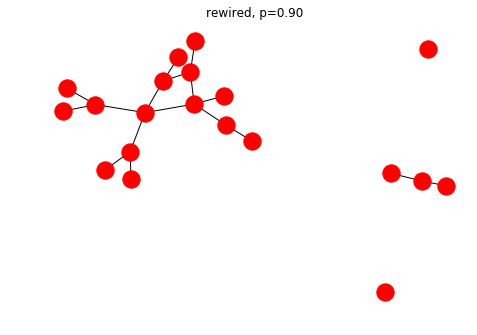

In [30]:
# Plot graphs with increasing rewiring.
for p in [0, .1, .5, .9]:
    plt.figure()
    rewired = rewire(nx.random_regular_graph(2, 20), p)
    nx.draw(rewired)
    plt.title('rewired, p=%.2f' % p)

**Main result of Watts & Strogatz:** *Even a small amount of rewiring results in a small world (low distance).*

![rewire](rewire.png)

$L \approx$ distance

$C \approx$ clustering coefficient

$p = $ rewiring probability



Can fit $p$ on a real graph and get a model that has similar 
- degree distribution
- clustering coefficient
- node distance

This allows us to compare and reason about graphs.

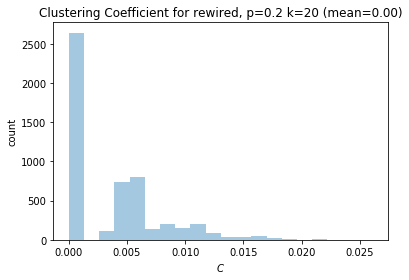

In [31]:
p = .2
k = 20
rewired_g = rewire(nx.random_regular_graph(k, len(coauthor.nodes())), p)
plot_clustering_dist(rewired_g, 'rewired, p=%g k=%d' % (p, k))

**Better, but still not perfect (missing spike x=~1.0)**  
([All models are wrong, but some are useful.](https://en.wikipedia.org/wiki/All_models_are_wrong))

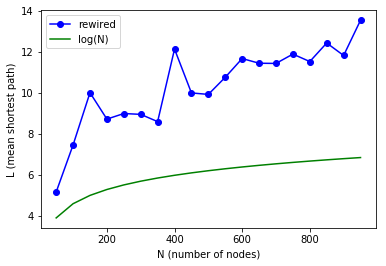

In [32]:
# Do rewired graphs obey L =~ log(N)?
Ls = []
ns = []
p = .5
for n in range(50,1000)[::50]:
    Ls.append(np.mean(get_shortest_paths(
                        rewire(nx.random_regular_graph(2, n), p))))
    ns.append(n)

plt.plot(ns, Ls, 'bo-', label='rewired')
plt.plot(ns, [math.log(n) for n in ns], 'g-', label='log(N)')
plt.legend(loc='upper left')
plt.xlabel('N (number of nodes)')
plt.ylabel('L (mean shortest path)')
plt.show()